# Условия задачи

Банк обратился за помощью, он хочет разработать кампанию лояльности по удержанию клиентов, для этого необходимо, выяснить основные причины оттока клиентов. Нужно **установить, чем ушедшие клиенты отличаются от лояльных и как между собой связаны различные признаки, определяющие клиентов.**

После разведовательного анализа, с целью выявления важных признаков оттока, банк планирует построить модель машинного обучения, которая будет прогнозировать уход клиента.

Основная задача - подготовить **мини-отчет о проведанной работе в виде ноутбука**. Отчет должен содержать ответы на список вопросов в виде графика и подробных выводов к ним.

## Инфомация об исходных данных

Данные об оттоке клиентов некоторого банка

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import plotly.express as px
%matplotlib inline
from IPython.display import Image

In [2]:
churn_data = pd.read_csv('data/churn.csv')
#churn_data.head()
#churn_data.info()

Столбцы таблицы:

1. *RowNumber* - номер строки таблицы (информация лишняя, можем удалить)
2. *CustomerId* - идентификатор клиента
3. *Surname* - фамилия клиента
4. *CreditScore* - кредитный рейтинг (чем выше, тем больше клиент брал кредитов и возвращал их)
5. *Geography* - страна клиента (банк международный)
6. *Gender* - пол клиента
7. *Age* - возраст клиента
8. *Tenure* - сколько лет клиент пользуется услугами банка
9. *Balance* - баланс на счетах клиента
10. *NumOfProducts* - количество услуг банка, которые приобрел клиент
11. *HasCrCard* - если у клиента кредитная карта (1 - да, 0 - нет)
12. *IsActiveMember* - есть ли у клиента статус активного клиента банка (1 - да, 0 - нет)
13. *EstimatedSalary* - предполагаемая заработная плата клиента
14. *Exited* - статус лояльности (1 - ушедший клиент, 0 - лояльный клиент)

# Отчет

## Предварительная обработка данных

In [3]:
# Делаю копию, во избежание потери данных
churn_df = churn_data.copy(deep=True)

# Удаляю лишнее
churn_df.drop(['RowNumber'], axis=1, inplace=True)

# Перевожу в человекочитаемый формат, некоторые столбцы
churn_df['HasCrCard'] = churn_df['HasCrCard'].replace({1: 'yes', 0: 'no'})
churn_df['IsActiveMember'] = churn_df['IsActiveMember'].replace({0 : 'Non active', 1 : 'Active'})
churn_df['ExitedLoyal'] = churn_df['Exited'].replace({0 : 'Loyal', 1 : 'Exited'}) # оставила object, category дает ошибку на графике

# Заменяю типы данных
churn_df['CreditScore'] = churn_df['CreditScore'].astype('int16')
churn_df['Age'] = churn_df['Age'].astype('int8')
churn_df['Exited'] = churn_df['Exited'].astype('int8')

cols_to_category = [
    'Geography', 
    'Gender', 
    'Tenure', 
    'NumOfProducts', 
    'HasCrCard', 
    'IsActiveMember',
    'ExitedLoyal'
]
for col in churn_df.columns:
    if col in cols_to_category:
        churn_df[col] = churn_df[col].astype('category')
        
#churn_df.info()

## Построение графиков

### **Задание 1**

Каково соотношение ушедших и лояльных клиентов? Покажите это на графике и дайте комментарий по соотношению.

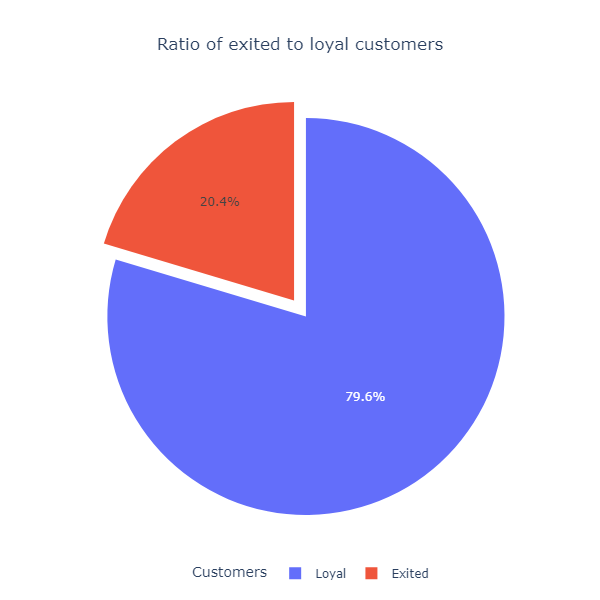

In [4]:
fig_1 = px.pie(
    data_frame=churn_df,
    values=churn_df['ExitedLoyal'].value_counts().values,
    names=churn_df['ExitedLoyal'].value_counts().index,
    title='Ratio of exited to loyal customers',
    width=600,
    height=600
)

fig_1.update_traces(pull = 0.05) # смещение 'пирога'

fig_1.update_layout(
    legend_title_text='Customers',
    legend_orientation="h",
    legend_x = 0.25,
    title_x = 0.5
)

#fig_1.show()
#fig_1.write_html("data/fig_1.html")
Image('data/fig_1.png')

**Выводы:**
Согласно данному графику 20% от всех клиентов, то есть каждый 5 клиент уходит из банка.

### **Задание 2**

Постройте график, показывающий распределение баланса пользователей, у которых на счету больше 2 500 долларов. Опишите распределение и сделайте выводы.

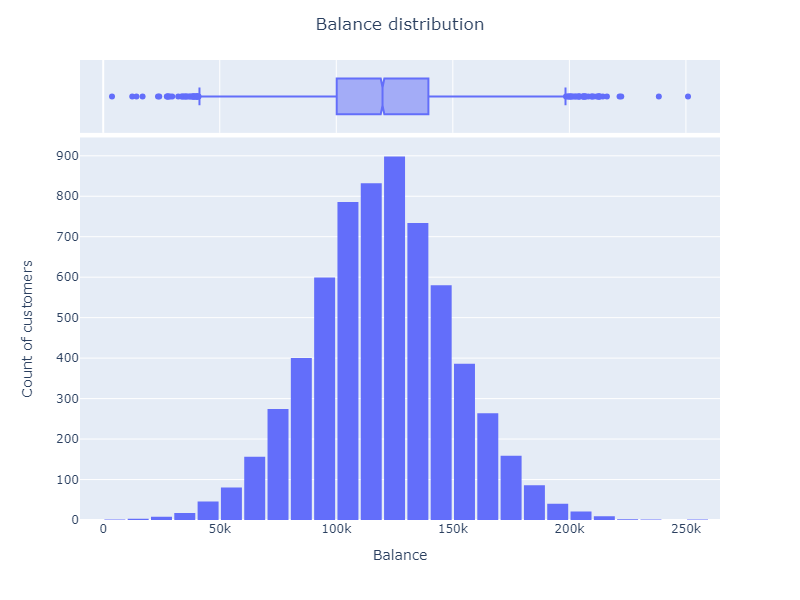

In [5]:
balans_more_2500 = churn_df[churn_df['Balance'] > 2500]

fig_2 = px.histogram(
    data_frame=balans_more_2500,
    x='Balance',
    nbins=25,
    marginal="box",
    height=600,
    width=800
    
)

fig_2.update_layout(
    title_text='Balance distribution',  # название графика
    yaxis_title_text='Count of customers',
    bargap=0.1,  # промежуток между полосами координат соседнего местоположения
    title_x=0.5
)

#fig_2.show()
#fig_2.write_html("data/fig_2.html")
Image('data/fig_2.png')

**Выводы:** График показывает 'нормальное' распределение. Основное количество клиентов имеет на счетах от 100 до 140 тыс. доларов. Медианный баланс 120 тыс. доларов. Менее 40 тыс. и более 200 тыс. имеет на счетах не значительное количество клиентов.

### **Задание 3**

Посмотрите на распределение баланса клиента в разрезе признака оттока. Как различаются суммы на накопительном счёте ушедших и лояльных клиентов? Подумайте и напишите, с чем это может быть связано, что может не устраивать ушедших клиентов в банке.

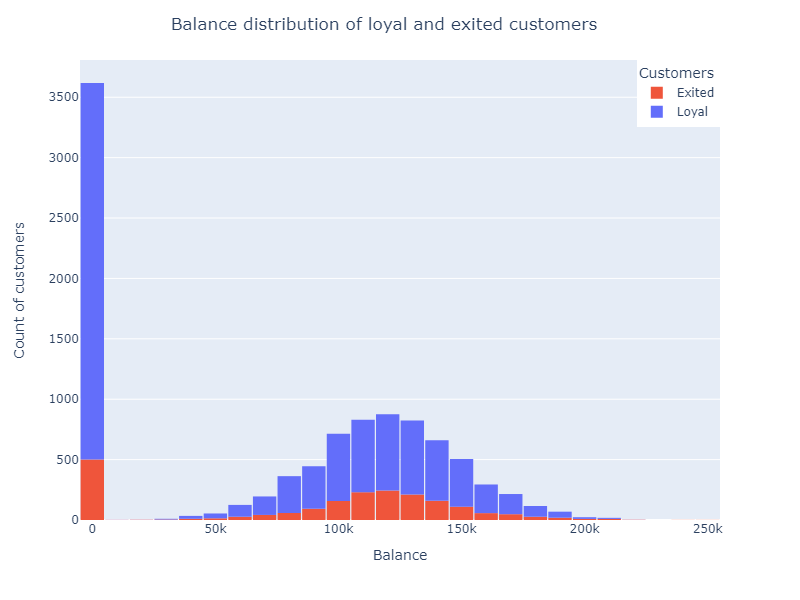

In [6]:
fig_3 = px.histogram(
    data_frame=churn_df,
    x='Balance',
    color='ExitedLoyal',
    nbins=30,
    #marginal="box",
    color_discrete_sequence=['#EF553B', '#636EFA'], # настройки цвета
    height=600,
    width=800
)

fig_3.update_layout(
    title_text='Balance distribution of loyal and exited customers',
    yaxis_title_text='Count of customers',
    bargap=0.05,
    title_x=0.48,
    legend_title_text='Customers',
    legend_x = 0.87 #координаты легенды
)
#fig_3.show()
#fig_3.write_html("data/fig_3.html")
Image('data/fig_3.png')

**Выводы:**
1. У 35% клиентов баланс счета находится в пределах 10 тыс. доларов, отток клиентов из этой категории минимальный - менее 15% (около 500 человек из 3500).

2. Вторая категория клиентов, имеющие на счетах более 10 тыс. доларов, отчего очевидно являются более важными клиентами, показывают нормальное распределение, в среднем отток клиентов этой категории около 20%, Однако на медианном значении их баланса (110-130 тыс. доларов) наблюдается увеличение оттока клиентов до 27% (244 клиента из 875).

3. Клиенты имеющие наибольший баланс (ближе к 250 тыс.) на счетах ушли из банка.

Банку необходимо обратить более пристальное внимание на категории клиентов имеющих значительные накопления на счетах.

### **Задание 4**

Посмотрите на распределение возраста в разрезе признака оттока. В какой группе больше потенциальных выбросов? На какую возрастную категорию клиентов стоит обратить внимание банку?

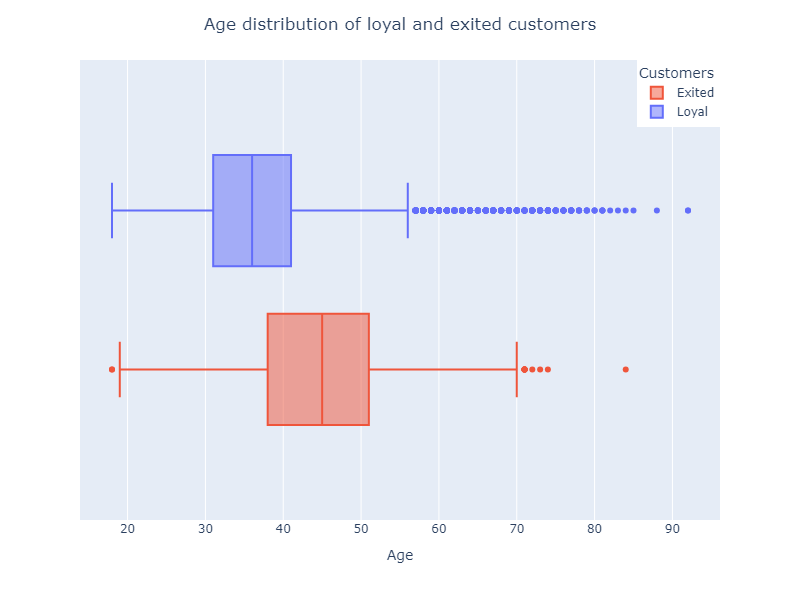

In [7]:
fig_4 = px.box(
    data_frame=churn_df,
    x='Age',
    color='ExitedLoyal',
    height=600,
    width=800,
    color_discrete_sequence=['#EF553B', '#636EFA']
)

fig_4.update_layout(
    title_text='Age distribution of loyal and exited customers',  # название графика
    title_x=0.5,
    legend_title_text='Customers',
    legend_x = 0.87,
    legend_y = 1
)
#fig_4.show()
#fig_4.write_html("data/fig_4.html")
Image('data/fig_4.png')

**Выводы:**
Потенциальных выбросов гораздо больше в группе лояльных клиентов, однако это показывает, что у банка достаточно лояльных клиентов во всех категориях возраста. Основное количество лояльных клиентов гораздо младше (31-41 год) чем основное количество ушедших (38-51 лет), это говорит о том, что Банку имеет смысл уделить больше внимания на группу более старшего рабочего возраста, создав для них более комфортные условия.

### **Задание 5**

Постройте график, который показывает взаимосвязь кредитного рейтинга клиента и его предполагаемой зарплаты. Добавьте расцветку по признаку оттока клиентов. Какова взаимосвязь между признаками? Если не видите явной взаимосвязи, укажите это.

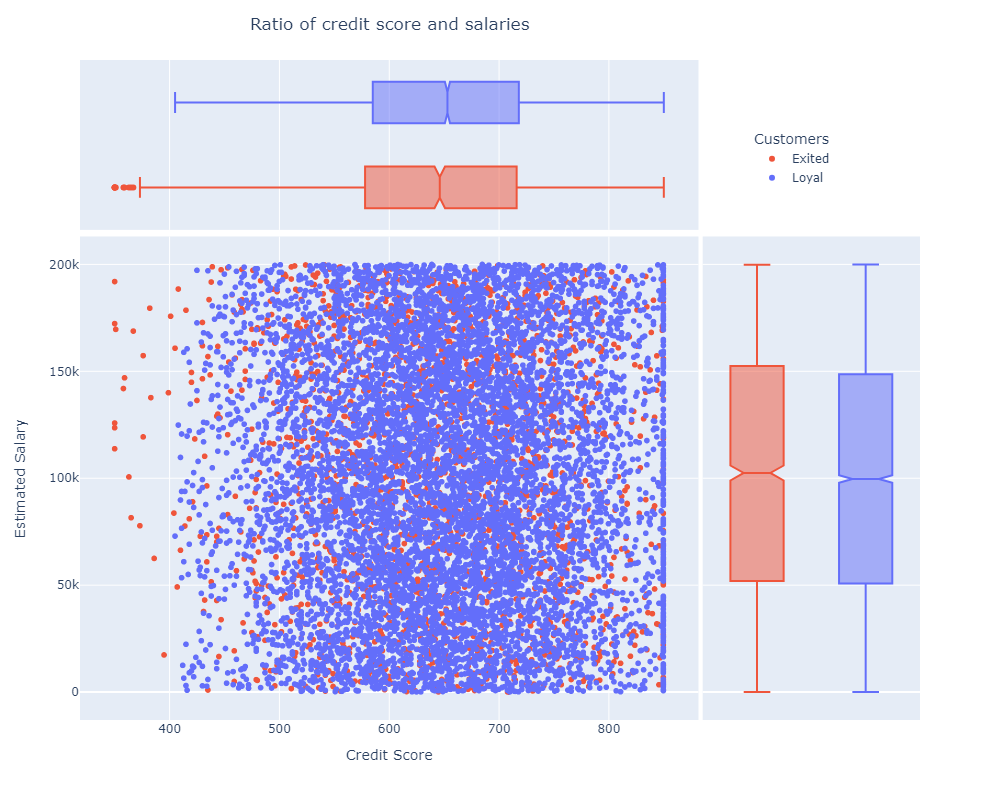

In [8]:
fig_5 = px.scatter(
    data_frame=churn_df,
    x='CreditScore',
    y='EstimatedSalary',
    color='ExitedLoyal',
    marginal_x="box", #дополнительные графики по осям
    marginal_y="box",
    #log_x=True,
    height=800,
    width=1000,
    #color_discrete_sequence=px.colors.qualitative.Plotly
    color_discrete_sequence=['#EF553B', '#636EFA']
)
fig_5.update_layout(
    title_text='Ratio of credit score and salaries',  # название графика
    yaxis_title_text='Estimated Salary',
    xaxis_title_text='Credit Score',
    #bargap=0.1,
    title_x=0.25,
    legend_title_text='Customers',
    legend_x = 0.8,
    legend_y = 0.9,
)

#fig_5.show()
#fig_5.write_html("data/fig_5.html")
Image('data/fig_5.png')

**Выводы:** Взаимосвязь между уровнем зарабатной платы и кредитным рейтингом отсуствует. В разрезе признаков оттока клиентов, виден незначительный сдвиг, лояльные клиенты как правило имеют кредитный рейтинг выше 400 пп., все клиенты с рейтингом ниже 400 - ушедшие клиенты. С максимальным кредитным рейтингом - 850 пп. большая часть клиентов - лояльна.

### **Задание 6**

6. Кто чаще уходит, мужчины или женщины? Постройте график, который иллюстрирует это.

In [9]:
# Определим количество лояльных и ушедших мужчин и женщин
group_gender = churn_df.groupby(by='Gender')['ExitedLoyal'].value_counts()
# переопределим в DF
group_gender_df = pd.DataFrame(group_gender)

# Определяю это же соотношение в %
percent_for_exited = churn_df.groupby(by=['Gender'])['Exited'].mean() #для ушедших
percent_for_loyal = 1-percent_for_exited # для лояльных
group_gender_p = pd.concat(
    [percent_for_exited, percent_for_loyal], 
    axis=0
    ).sort_values().apply(lambda x: f'{x:.1%}') #объединяю, сортирую, форматирую

#Соединяю все данные в нужную мне таблицу
group_gender_df = group_gender_df.sort_values(by=['count'])
group_gender_df['percent'] = group_gender_p.values
group_gender_df.reset_index(inplace=True, level = 'ExitedLoyal')
group_gender_df = group_gender_df.sort_values(by=['Gender', 'count'])

#display(group_gender_df)


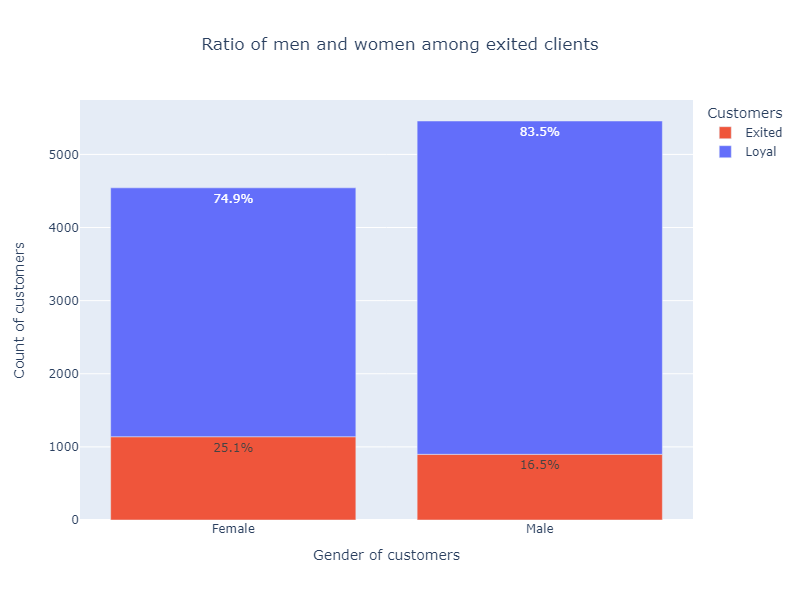

In [10]:
fig_6 = px.bar(
    data_frame=group_gender_df,
    x=group_gender_df.index,
    y='count',
    color='ExitedLoyal',
    title='Ratio of men and women among еxited clients',
    color_discrete_sequence=['#EF553B', '#636EFA'],
    text=group_gender_df['percent'],
    height=600,
    width=800,
)

fig_6.update_layout(
    yaxis_title_text='Count of customers',
    xaxis_title_text='Gender of customers',
    title_x = 0.5,
    legend_title_text='Customers'
)

#fig_6.show()
#fig_6.write_html("data/fig_6.html")
Image('data/fig_6.png')

**Выводы:** В процентном соотношении женщины уходят из банка чаще чем мужчины (примерно на 10%), однако в абсолютном значении мужчины чаще являются клиентами банка, соответственно количество ушедших мужчин и женщин примерно одинаково.
Банку необходимо продумать системы лояльности для клиентов женского пола, не только для их "удержания", но и привлечения в банк.

### **Задание 7**

Как отток клиентов зависит от числа приобретённых у банка услуг? Для ответа на этот вопрос постройте многоуровневую столбчатую диаграмму.

In [11]:
# Группирую данные по кол-ву приобретенных продуктов и оттоку
group_prod = pd.DataFrame(churn_df.groupby('NumOfProducts')['ExitedLoyal'].value_counts())
group_prod.reset_index(inplace=True) #сбрасываю мультииндекс

#Добавляю столбец с данными в %
group_prod['percent'] = (group_prod['count'] / group_prod['count'].sum()).apply(lambda x: f'{x:.1%}')

group_prod= group_prod.sort_values(by=['NumOfProducts', 'count'])
#display(group_prod)

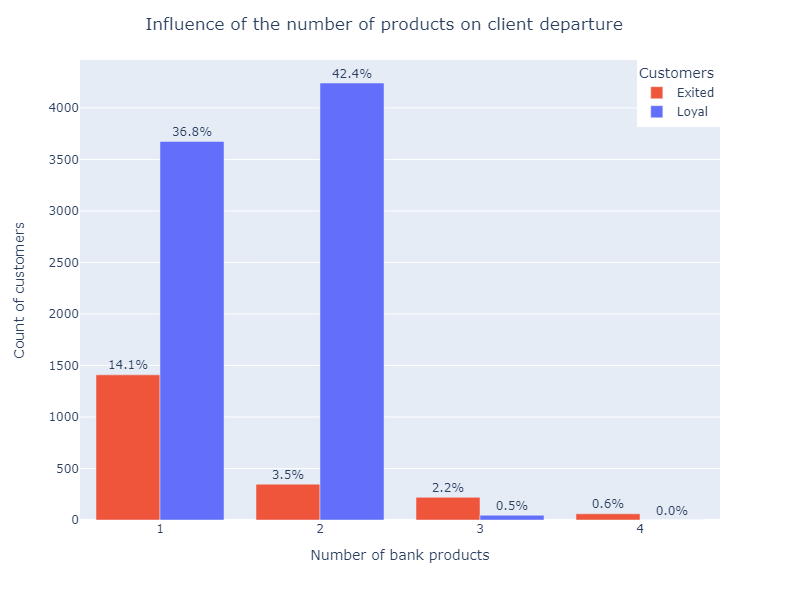

In [12]:
fig_7 = px.bar(
    data_frame=group_prod,
    x='NumOfProducts',
    y='count',
    color='ExitedLoyal',
    # цвет по категории
    color_discrete_map={
        'Exited': '#EF553B',
        'Loyal': '#636EFA'
    },
    text='percent', # ссылка на столбец с подписью
    barmode='group', # метод отображения group-рядом, знач. не суммирует
    height=600,
    width=800,
)
fig_7.update_layout(
    title_text='Influence of the number of products on client departure',
    yaxis_title_text='Count of customers',
    xaxis_title_text='Number of bank products',
    title_x=0.48,
    legend_title_text='Customers',
    legend_x = 0.87,
    legend_y = 1
    
)
fig_7.update_traces(textposition='outside')

#fig_7.show()
#fig_7.write_html("data/fig_7.html")
Image('data/fig_7.png')

**Выводы:** Основное количество лояльных клиентов банка пользуется не более двумя услугами банка. 
Ни одного лояльного клиента не воспользовалась 4 услугами банка, 1% воспользовавшихся - ушедшие клиенты. 
В целом более 2 услуг использует менее 4% клиентов банка. 
Основное количество ушедших клиентов, не обращается в банк повторно (подавляющее число клиентов ушло после одной преобретенной услуги).

### **Задание 8**

Как влияет наличие статуса активного клиента на отток клиентов? Постройте диаграмму, иллюстрирующую это. Что бы вы предложили банку, чтобы уменьшить отток клиентов среди неактивных?

In [13]:
# Группирую данные по статусу активности клиента и оттоку
group_active = pd.DataFrame(churn_df.groupby('IsActiveMember')['ExitedLoyal'].value_counts())
group_active.reset_index(inplace=True)

# Добавляю данные в долях
group_active['percent'] = churn_df.groupby(by='IsActiveMember')[['ExitedLoyal']].value_counts(normalize=True).values
group_active['percent'] = group_active['percent'].apply(lambda x: f'{x:.1%}')

group_active = group_active.sort_values(by=['IsActiveMember', 'count'])
#display(group_active)

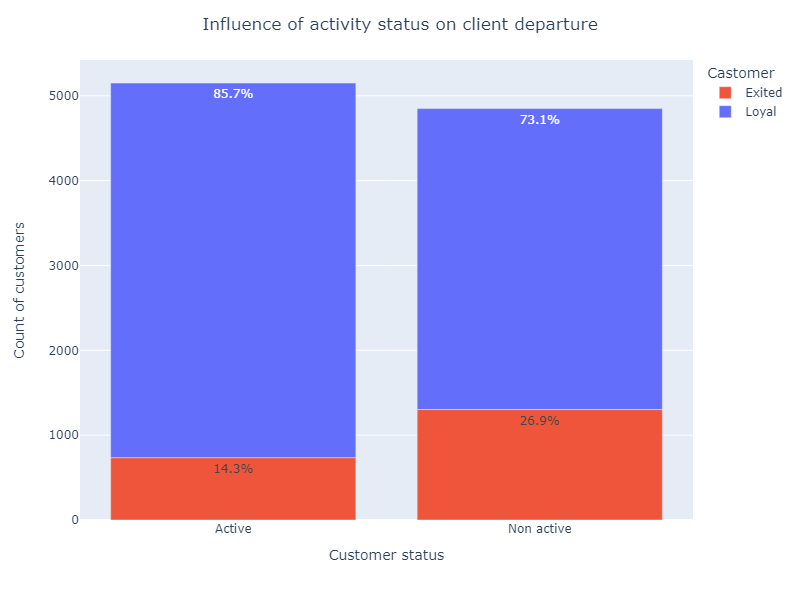

In [14]:
fig_8 = px.bar(
    data_frame=group_active,
    x='IsActiveMember',
    y='count',
    color='ExitedLoyal',
    color_discrete_map={
        'Exited': '#EF553B',
        'Loyal': '#636EFA'
    },
    text='percent',
    #barmode='group',
    height=600,
    width=800,
)
fig_8.update_layout(
    title_text='Influence of activity status on client departure',
    yaxis_title_text='Count of customers',
    xaxis_title_text='Customer status',
    title_x=0.5,
    legend_title_text='Castomer',
)
#fig_8.show()
#fig_8.write_html("data/fig_8.html")
Image('data/fig_8.png')

**Выводы:** В абсолютном значении, количество активных и не активных клиентов примерно одинаково. 
В процентном отношении очевидно, что не активные клиенты уходят из банка в 2 раза чаще активных. 
Соответственно, банку необходимо принять меры по стимулируванию не активных клиентов, побуждая пользоваться счетами чаще (программы лояльности, кэш-бэк).

### **Задание 9**

В какой стране доля ушедших клиентов больше? Постройте тепловую картограмму, которая покажет это соотношение на карте мира. Предположите, с чем это может быть связано.

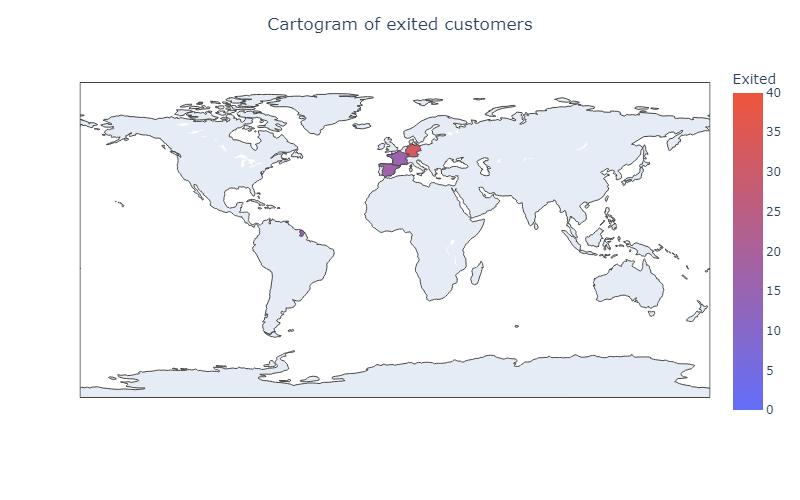

In [15]:
#Расчитаем долю ушудших клиентов по странам
choropleth_data = churn_data.groupby(by='Geography')['Exited'].mean().round(2) * 100

fig_9 = px.choropleth(
    data_frame=choropleth_data,
    locations=choropleth_data.index,
    locationmode='country names',
    color='Exited',
    height=500,
    width=800,
    range_color=[0,40], #диапазон цвета
    color_continuous_scale=['#636EFA', '#EF553B']
)
fig_9.update_layout(
    title_text='Cartogram of exited customers',
    title_x=0.5
)
#fig_9.show()
#fig_9.write_html("data/fig_9.html")
Image('data/fig_9.png')

In [16]:
display(churn_data.groupby(by='Geography').mean(numeric_only=True).round(2))
#churn_data['Geography'].value_counts()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
Geography,,,,,,,,,,,
France,5025.23,15690650.11,649.67,38.51,5.00,62092.64,1.53,0.71,0.52,99899.18,0.16
Germany,5000.28,15690555.65,651.45,39.77,5.01,119730.12,1.52,0.71,0.50,101113.44,0.32
Spain,4950.67,15691918.41,651.33,38.89,5.03,61818.15,1.54,0.69,0.53,99440.57,0.17


**Выводы:** В Германии доля ушедших клиентов наибольшая - составляет 32%. 

Единственную взаимосвязь которую можно проследить из таблицы средних значений по странам, это средний уровень баланса счета. В Германии баланс на счетах клиентов в среднем выше в 2 раза чем в других странах. Исходя из этого можно предположить, что так как клиенты "более богаты", у них и требования к банку повышенные. Или у банка не достаточно программ для привлечения "более бедных" клиентов.

### **Задание 10**

Переведите числовой признак CreditScore в категориальный. Для этого воспользуйтесь функцией get_credit_score_cat(), которая приведена ниже. Примените её к столбцу CreditScore и создайте новый признак CreditScoreCat — категории кредитного рейтинга.

Постройте сводную таблицу, строками которой являются категории кредитного рейтинга (CreditScoreCat), а столбцами — количество лет, в течение которых клиент пользуется услугами банка (Tenure). В ячейках сводной таблицы должно находиться среднее по признаку оттока (Exited) — доля ушедших пользователей.

На основе полученной сводной таблицы постройте тепловую карту с аннотацией. Найдите на тепловой карте категории клиентов, которые уходят чаще всего.

In [17]:
def get_credit_score_cat(credit_score):
    if credit_score >= 300 and credit_score < 500:
        return "Very_Poor"
    elif credit_score >= 500 and credit_score < 601:
        return "Poor"
    elif credit_score >= 601 and credit_score < 661:
        return "Fair"
    elif credit_score >= 661 and credit_score < 781:
        return "Good"
    elif credit_score >= 781 and credit_score < 851:
        return "Excellent"
    elif credit_score >= 851:
        return "Top"
    elif credit_score < 300:
        return "Deep"
    
churn_data['CreditScoreCat'] = churn_data['CreditScore'].apply(get_credit_score_cat)

pivot = churn_data.pivot_table(
    values='Exited',
    index='CreditScoreCat',
    columns='Tenure'
).round(3) * 100

#display(pivot)

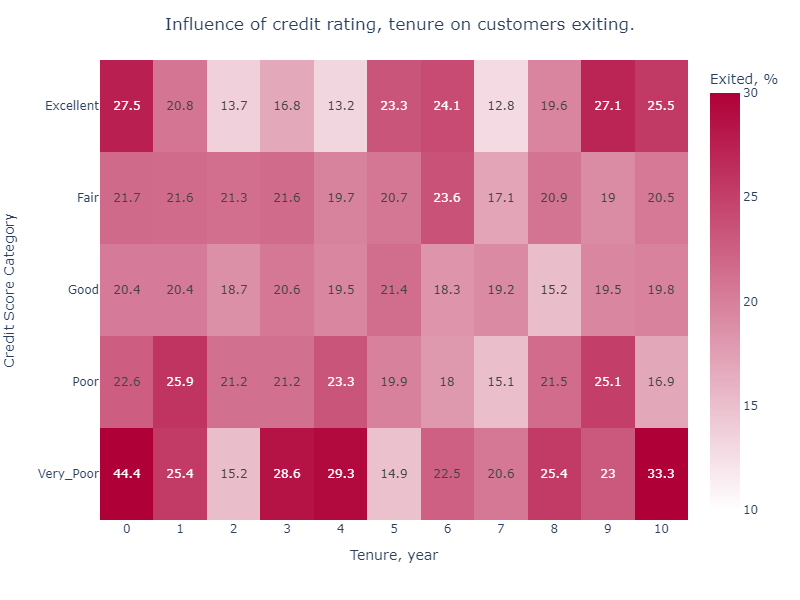

In [18]:
fig_10 = px.imshow(
    pivot, 
    text_auto=True, 
    aspect="auto", #позволяет растянуть квадраты
    range_color=[10,30],
    labels=dict(
        x="Tenure, year", 
        y="Credit Score Category", 
        color="Exited, %"
    ),
    x=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10'],
    height=600,
    width=800,
    color_continuous_scale=['white', px.colors.qualitative.Dark24[23]] #ссылка на палитру цветов
)

fig_10.update_layout(
    title_text='Influence of credit rating, tenure on customers exiting.',
    title_x=0.5,
)
#fig_10.show()
#fig_10.write_html("data/fig_10.html")
Image('data/fig_10.png')

**Выводы:** Чаще всего банк покидают клиенты категории "Очень бедные", наибольшая частота зафиксирована, у клиентов, которые не были клиентами банка и года - 44%, и наоборот у постоянных клиентов (10 лет) - 33%. 
Достаточно часто банк покидают и клиенты с превосходной кредитной историей, причем отток зафиксирован как у постоянных клиентов (25-27%), так и у новых клиентов 21-28%. 